In [1]:
%matplotlib nbagg

#visualizations
import matplotlib 
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
#core imports
import numpy as np
import math
from scipy.stats import norm
from sklearn.neighbors import KDTree

#NN
import tensorflow as tf

In [2]:
#NP core
from npfunc_batch import loglikelihood2, loglikelihood3, kl_qp_gauss, dist_bd
from npfunc_batch import posterior_predict, prior_predict, init_neural_process, g_act
#optimization
from npopt_batch import np_iteration, sample_curves, expected_improvement, get_next_sample
#plotting
from npplot import plot_np_fit_1d

In [3]:
#network parameters
dim_r = 16
dim_z = 16
dim_h_hidden = [128, 64, 32]
dim_g_hidden = [128, 64, 32]

In [4]:
#define batch size
batch_size = 1

In [5]:
#create placeholders for the data
x_context = tf.placeholder(tf.float32, shape=(batch_size, None, 1))
y_context = tf.placeholder(tf.float32, shape=(batch_size, None, 1))
x_target = tf.placeholder(tf.float32, shape=(batch_size, None, 1))
y_target = tf.placeholder(tf.float32, shape=(batch_size, None, 1))

In [6]:
#define training operation and loss function
noise_sd = 0.1
activation_function = tf.nn.sigmoid
train_op_and_loss = init_neural_process(x_context, y_context, x_target, y_target, 
                                        dim_h_hidden, dim_g_hidden, dim_r, dim_z, 
                                        loglikelihood2, noise_sd = noise_sd, lrv= 0.001, 
                                        act_f=activation_function, n_draws = 100)

In [7]:
#run on cpu since we are dealing with batch size 1 
config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )

In [8]:
#create interactive session
init = tf.global_variables_initializer()
sess = tf.InteractiveSession(config=config)
sess.run(init)

In [9]:
#define a function to predict 
def f(x):
    """The function to predict."""
    return x*x * np.sin(x)

In [10]:
#range for predictions and true values
n_t = 100
x_t = np.atleast_3d(np.linspace(-5, 17, n_t)).T.astype(np.float32)
y_t = f(x_t).astype(np.float32)

In [11]:
#initialize random point and compute its value
#x_0 = np.random.randint(low=0, high=x_t.shape[0], size=3)
x_0 = [ 0, np.random.randint(low=0, high=x_t.shape[1]), x_t.shape[1] - 1]
x_data = x_t[:, x_0]
y_data = y_t[:, x_0]

<IPython.core.display.Javascript object>


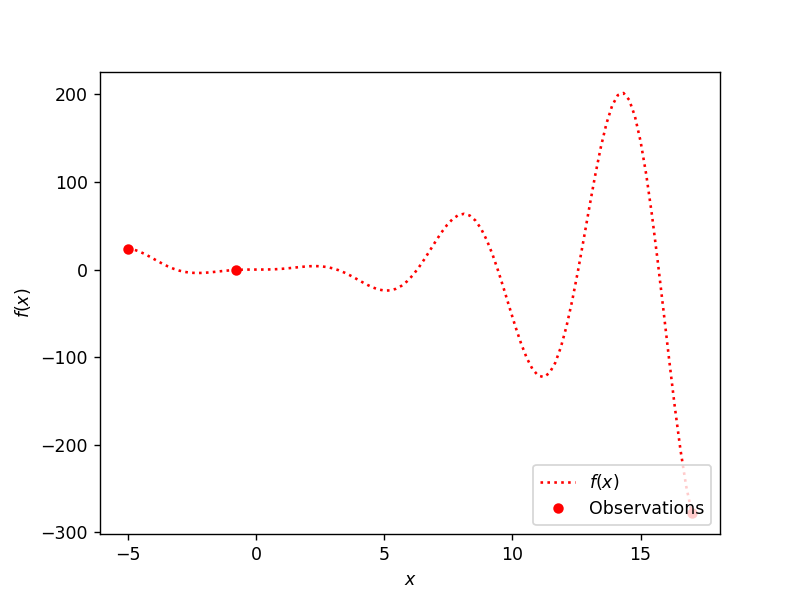

In [12]:
#plot the function
fig = plt.figure()
plt.plot(x_t[0], y_t[0], 'r:', label=u'$f(x)$')
plt.plot(x_data[0], y_data[0], 'r.', markersize=10, label=u'Observations')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='lower right')

In [13]:
#save the history 
y_history_mean = np.zeros(shape = (0, batch_size, n_t))
y_history_sigma = np.zeros(shape = (0, batch_size, n_t))

In [14]:
#number of points to sample 
n_points = 17
#number of training steps at each point and how often to print loss
n_steps = 20000
p_freq = 2000 
#number of samples from latent variable space
n_draws = 100

for p in range(n_points): 
    print("Point: ", p)
    #train NP
    
    #early stopping if converged
    for i in range(n_steps):
    #while loss > 0:
        #perform 1 np iteration 
        a = np_iteration(x_data, y_data, x_context, y_context, 
                         x_target, y_target, sess, train_op_and_loss)
        loss = a[1]
        #print iteration and loss
        if(i % p_freq == 0):
            print(i, loss)
        if(loss < 0):
            break
    
    print(i, a[1])
    #compute mean and std of the samples
    y_star_mat, y_star_mean, y_star_sigma = sample_curves(x_data, y_data, x_t, 
                                            dim_h_hidden, dim_g_hidden, dim_r, dim_z,
                                            sess, epsilon_std=5.0 * np.sqrt((p + 1)), n_draws=n_draws, act_f=activation_function)
    
    print("Current maximum: ", np.amax(y_star_mean), ' at: ', x_t[:, np.argmax(y_star_mean[0, :]), :])
    
    #save the values in history 
    y_mean = y_star_mean.reshape( 1, y_star_mean.shape[0], y_star_mean.shape[1])
    y_sigma = y_star_sigma.reshape( 1, y_star_sigma.shape[0], y_star_sigma.shape[1])
    
    y_history_mean = np.append(y_history_mean, y_mean, axis=0)
    y_history_sigma = np.append(y_history_sigma, y_sigma, axis=0)

    
    #predict values of the observed data
    predict_op2 = posterior_predict(x_data, y_data, x_data, dim_h_hidden, dim_g_hidden, dim_r, dim_z, epsilon=None, n_draws=1, act_f=activation_function)
    y_star_mat2 = sess.run(predict_op2)
    
    #compute the acquisition function and get a new point
    ei = expected_improvement(y_star_mean, y_star_sigma, y_data, y_star_mat2[0])
    x_data_new, y_data_new = get_next_sample(x_t, np.argmax(ei), y_t=y_t)
    print("Evaluating at maximum acquisition function: ", x_data_new)

    #if already evaluated 
    if np.any(np.isclose(x_data_new, x_data)):
        
        #choose maximum uncertainty
        #sc_unc = (y_star_sigma *np.power(np.abs(((x_t - x_data[-1])/ (np.max(x_t) - np.min(x_t)))), 0.5).T)
        x_data_new, y_data_new = get_next_sample(x_t, np.argmax(y_star_sigma[0,:]), y_t=y_t)
        print("Already done, evaluating at most uncertainty: ", x_data_new)
        
        #or choose a random point
        if np.any(np.isclose(x_data_new, x_data)):
            rp = np.random.randint(low = 0, high = x_t.shape[1])
            x_data_new, y_data_new = get_next_sample(x_t, rp, y_t=y_t)
            print("Already done, evaluating at random point: ", x_data_new)

    x_data = np.append(x_data, x_data_new, axis=1)
    y_data = np.append(y_data, y_data_new, axis=1)

Point:  0
2000 857098.3
4000 565107.3
6000 342142.47
8000 180270.86
10000 74918.99
12000 19544.203
14000 1637.4375
16000 3.4625614
16245 -0.059186358
Current maximum:  23.967966  at:  [[-5.]]
Evaluating at maximum acquisition function:  [[[-5.]]]
Already done, evaluating at most uncertainty:  [[[0.11111111]]]
Point:  1
2000 4.542656
2466 -0.0012234412
Current maximum:  23.873415  at:  [[-5.]]
Evaluating at maximum acquisition function:  [[[-5.]]]
Already done, evaluating at most uncertainty:  [[[11.666667]]]
Point:  2
943 -0.01069532
Current maximum:  23.904482  at:  [[-5.]]
Evaluating at maximum acquisition function:  [[[-5.]]]
Already done, evaluating at most uncertainty:  [[[12.777778]]]
Point:  3
2000 82762.98
4000 82686.63
6000 82673.78
8000 82670.85
10000 82666.68
12000 6614.3584
14000 153027.7
16000 679.8483
18000 58.40267
19382 -0.0075414684
Current maximum:  33.863422  at:  [[13.]]
Evaluating at maximum acquisition function:  [[[13.]]]
Point:  4
2000 1443.3331
4000 4823.8457
6

<IPython.core.display.Javascript object>


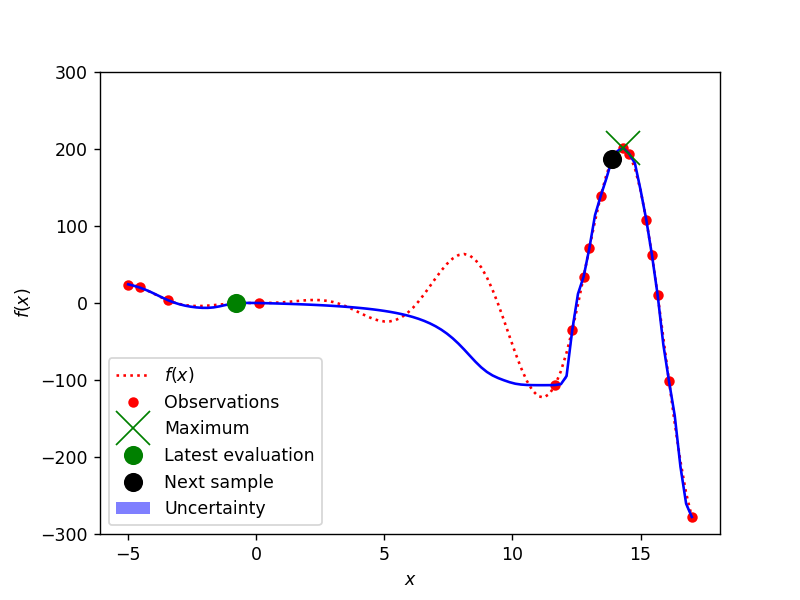

In [15]:
#plot the final fit 
fig1 = plot_np_fit_1d(x_t[0, :], y_t[0, :], x_data[0, :], y_data[0, :], y_star_mean[0, :], y_star_sigma[0, :], 10, ylim=(-300,300), lloc = "lower left", fignum=10)

<IPython.core.display.Javascript object>


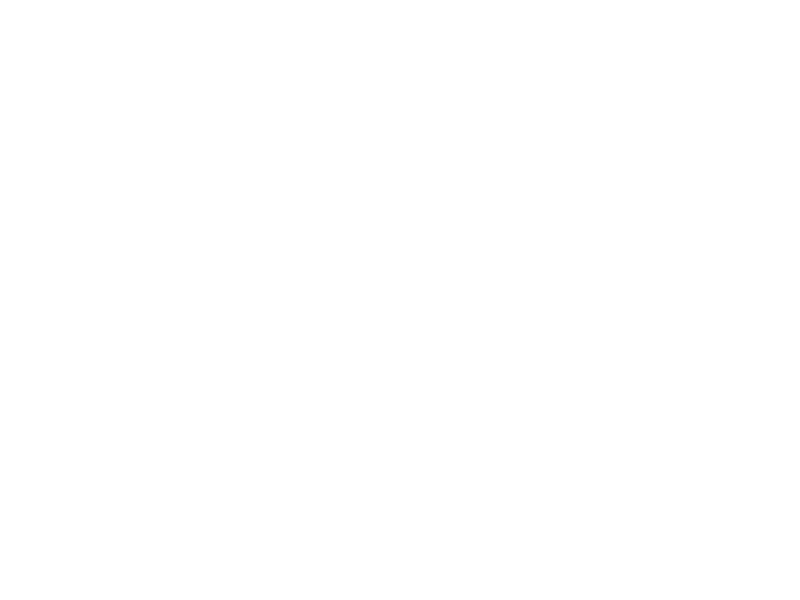

In [16]:
#plot the history and save the figures 
n_iter = y_history_mean.shape[0]
n_start = 3
path = "./Figures/1D/"
fname = "test_"
unc_scale = 1.0

for i in range(n_iter):
    fig1 = plot_np_fit_1d(x_t[0,:], y_t[0,:], x_data[0, 0:i+ n_start+1], y_data[0, 0:i+ n_start+1], 
                          y_history_mean[i, 0, :], y_history_sigma[i, 0, :], 
                          unc_scale, ylim=(-300,300), lloc = "lower left", fignum=20)
    fig1.savefig(path + fname + str(i) + '.png')
    fig1.clear()
    
plt.close(fig1)

<IPython.core.display.Javascript object>


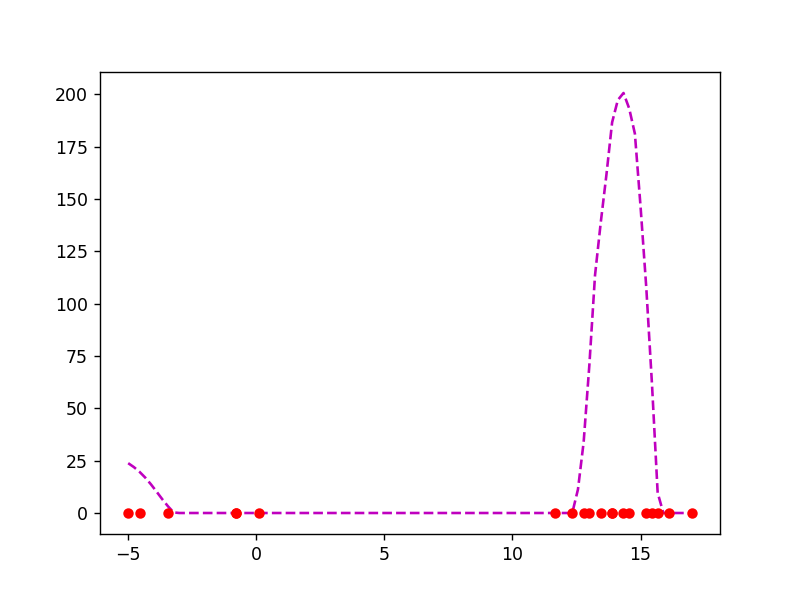

In [17]:
#plot the acquisition function 
fig = plt.figure()
plt.plot(x_t[0,:], ei[0,:], 'm--')
#plt.plot(x_t,  y_star_mean, 'b--')
plt.plot(x_data[0,:], np.zeros_like(x_data[0,:]), 'r.', markersize=10, label=u'Observations')

<IPython.core.display.Javascript object>


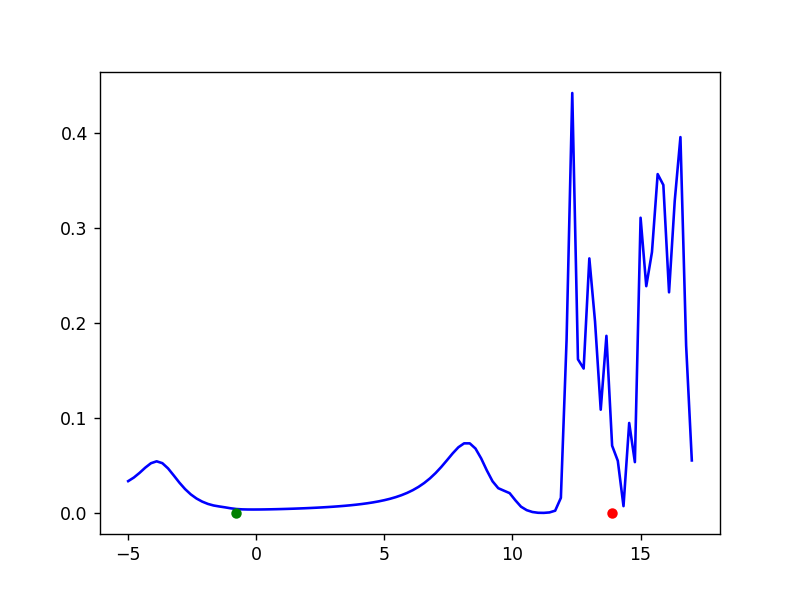

In [18]:
#we can look at std from generated curves 
fig = plt.figure()
plt.plot(x_t[0,:], y_star_sigma[0,:], 'b-')
plt.plot(x_data[:, -2], 0, 'g.', markersize=10, label=u'Last point')
plt.plot(x_data_new[0,:], 0, 'r.', markersize=10, label=u'Next point')
#plt.plot(x_t[0,:], (y_star_sigma[0,:] *np.power(np.abs(((x_t[0,:] - x_data[:, -2])/ (np.max(x_t[0,:]) - np.min(x_t[0,:])))), 0.5).T).T  , 'r--')

In [19]:
sess.close()